In [1]:
import requests
from scrapy import Selector
import json


In [2]:
url = "https://travelness.com/most-visited-cities-in-the-world"

response = requests.get(url)

table = Selector(response).css('table')
cities = table.xpath(".//tr/td[2]/text()").getall()

In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

/var/folders/z0/lgs3gf5503zcdkll0zsjwyx40000gn/T/ipykernel_38455/604743347.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [5]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 13.754,
    "longitude": 100.5014,
    "start_date": "2024-03-04",
    "end_date": "2024-03-18",
    "hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)


In [6]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 13.743409156799316°N 100.49586486816406°E
Elevation 7.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [7]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


                         date  temperature_2m
0   2024-03-04 00:00:00+00:00       27.406500
1   2024-03-04 01:00:00+00:00       29.806499
2   2024-03-04 02:00:00+00:00       30.906500
3   2024-03-04 03:00:00+00:00       31.256500
4   2024-03-04 04:00:00+00:00       32.556499
..                        ...             ...
355 2024-03-18 19:00:00+00:00       27.956501
356 2024-03-18 20:00:00+00:00       27.806499
357 2024-03-18 21:00:00+00:00       27.706501
358 2024-03-18 22:00:00+00:00       27.656500
359 2024-03-18 23:00:00+00:00       27.706501

[360 rows x 2 columns]


In [8]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": [39.55, 19.0728, 22.5455, 36.9081, 41.0138, 3.1412, 25.0772, 1.2897, 51.5085, 22.2783, 48.8534, 28.6519, 35.6895, 25.0478, 12.9333, 41.8919, 40.7143, 13.754],
    "longitude": [2.7333, 72.8826, 114.0683, 30.6956, 28.9497, 101.6865, 55.3093, 103.8501, -0.1257, 114.1747, 2.3488, 77.2315, 139.6917, 121.5319, 100.8833, 12.5113, -74.006, 100.5014],
    "start_date": "1940-01-01",
    "end_date": "2024-03-01",
    "daily": ["precipitation_sum", "rain_sum", "precipitation_hours"]
}
responses = openmeteo.weather_api(url, params=params)

In [9]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 39.54305648803711°N 2.742382287979126°E
Elevation 2.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [10]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()
daily_rain_sum = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["precipitation_hours"] = daily_precipitation_hours

daily_dataframe = pd.DataFrame(data = daily_data)
display(daily_dataframe)


,date,precipitation_sum,rain_sum,precipitation_hours
0,1940-01-01 00:00:00+00:00,NaN,NaN,0.0
1,1940-01-02 00:00:00+00:00,1.300000,1.300000,6.0
2,1940-01-03 00:00:00+00:00,6.400000,6.400000,13.0
3,1940-01-04 00:00:00+00:00,2.000000,2.000000,8.0
4,1940-01-05 00:00:00+00:00,0.000000,0.000000,0.0
...,...,...,...,...
30737,2024-02-26 00:00:00+00:00,8.400000,8.400000,8.0
30738,2024-02-27 00:00:00+00:00,0.400000,0.400000,4.0
30739,2024-02-28 00:00:00+00:00,6.099999,6.099999,14.0
30740,2024-02-29 00:00:00+00:00,0.000000,0.000000,0.0


In [11]:
# doing it just for London 


import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "start_date": "1940-01-01",
    "end_date": "2024-03-01",
    "daily": ["precipitation_sum", "precipitation_hours"]
}
responses = openmeteo.weather_api(url, params=params)


OpenMeteoRequestsError: {'error': True, 'reason': 'Minutely API request limit exceeded. Please try again in one minute.'}

In [13]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "start_date": "1940-01-01",
    "end_date": "2024-03-01",
    "daily": ["precipitation_sum", "precipitation_hours"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_hours"] = daily_precipitation_hours

daily_dataframe = pd.DataFrame(data = daily_data)
display(daily_dataframe)

OpenMeteoRequestsError: {'reason': 'Hourly API request limit exceeded. Please try again in the next hour.', 'error': True}

/var/folders/z0/lgs3gf5503zcdkll0zsjwyx40000gn/T/ipykernel_38455/1436297354.py:19: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


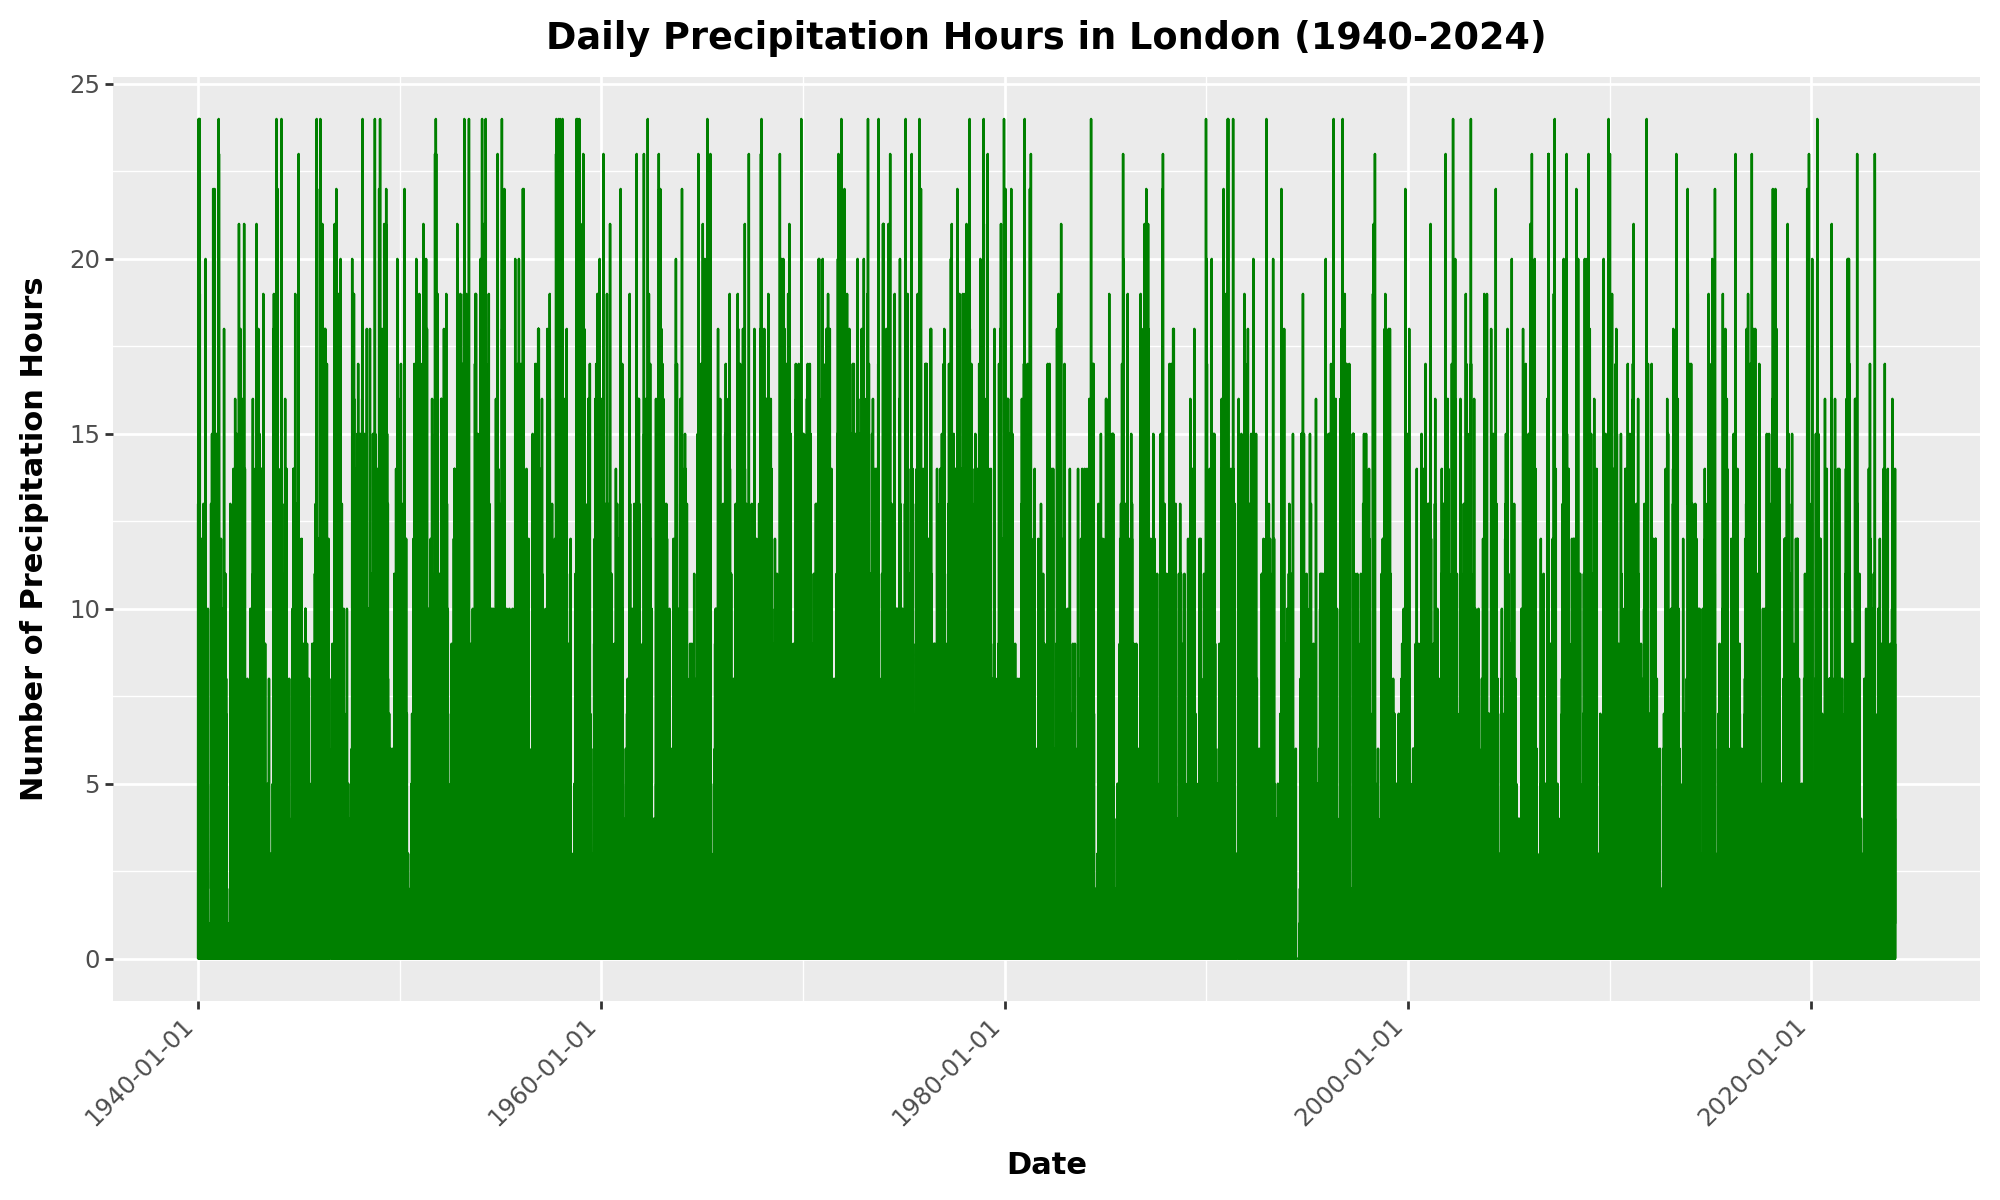

In [14]:

from plotnine import ggplot, aes, geom_line, labs, theme, element_text
from pandas.plotting import register_matplotlib_converters

# Registering converters to avoid warning messages
register_matplotlib_converters()

# Creating a plot using Plotnine
plot = (ggplot(daily_dataframe) +
        aes(x='date', y='precipitation_hours') +
        geom_line(color='green') +
        labs(title='Daily Precipitation Hours in London (1940-2024)', x='Date', y='Number of Precipitation Hours') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6))  # Adjust the figure size
       )

# Displaying the plot
print(plot)

from plotnine import ggplot, aes, geom_line, labs, theme, element_text
from pandas.plotting import register_matplotlib_converters

/var/folders/z0/lgs3gf5503zcdkll0zsjwyx40000gn/T/ipykernel_38455/1482463063.py:16: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


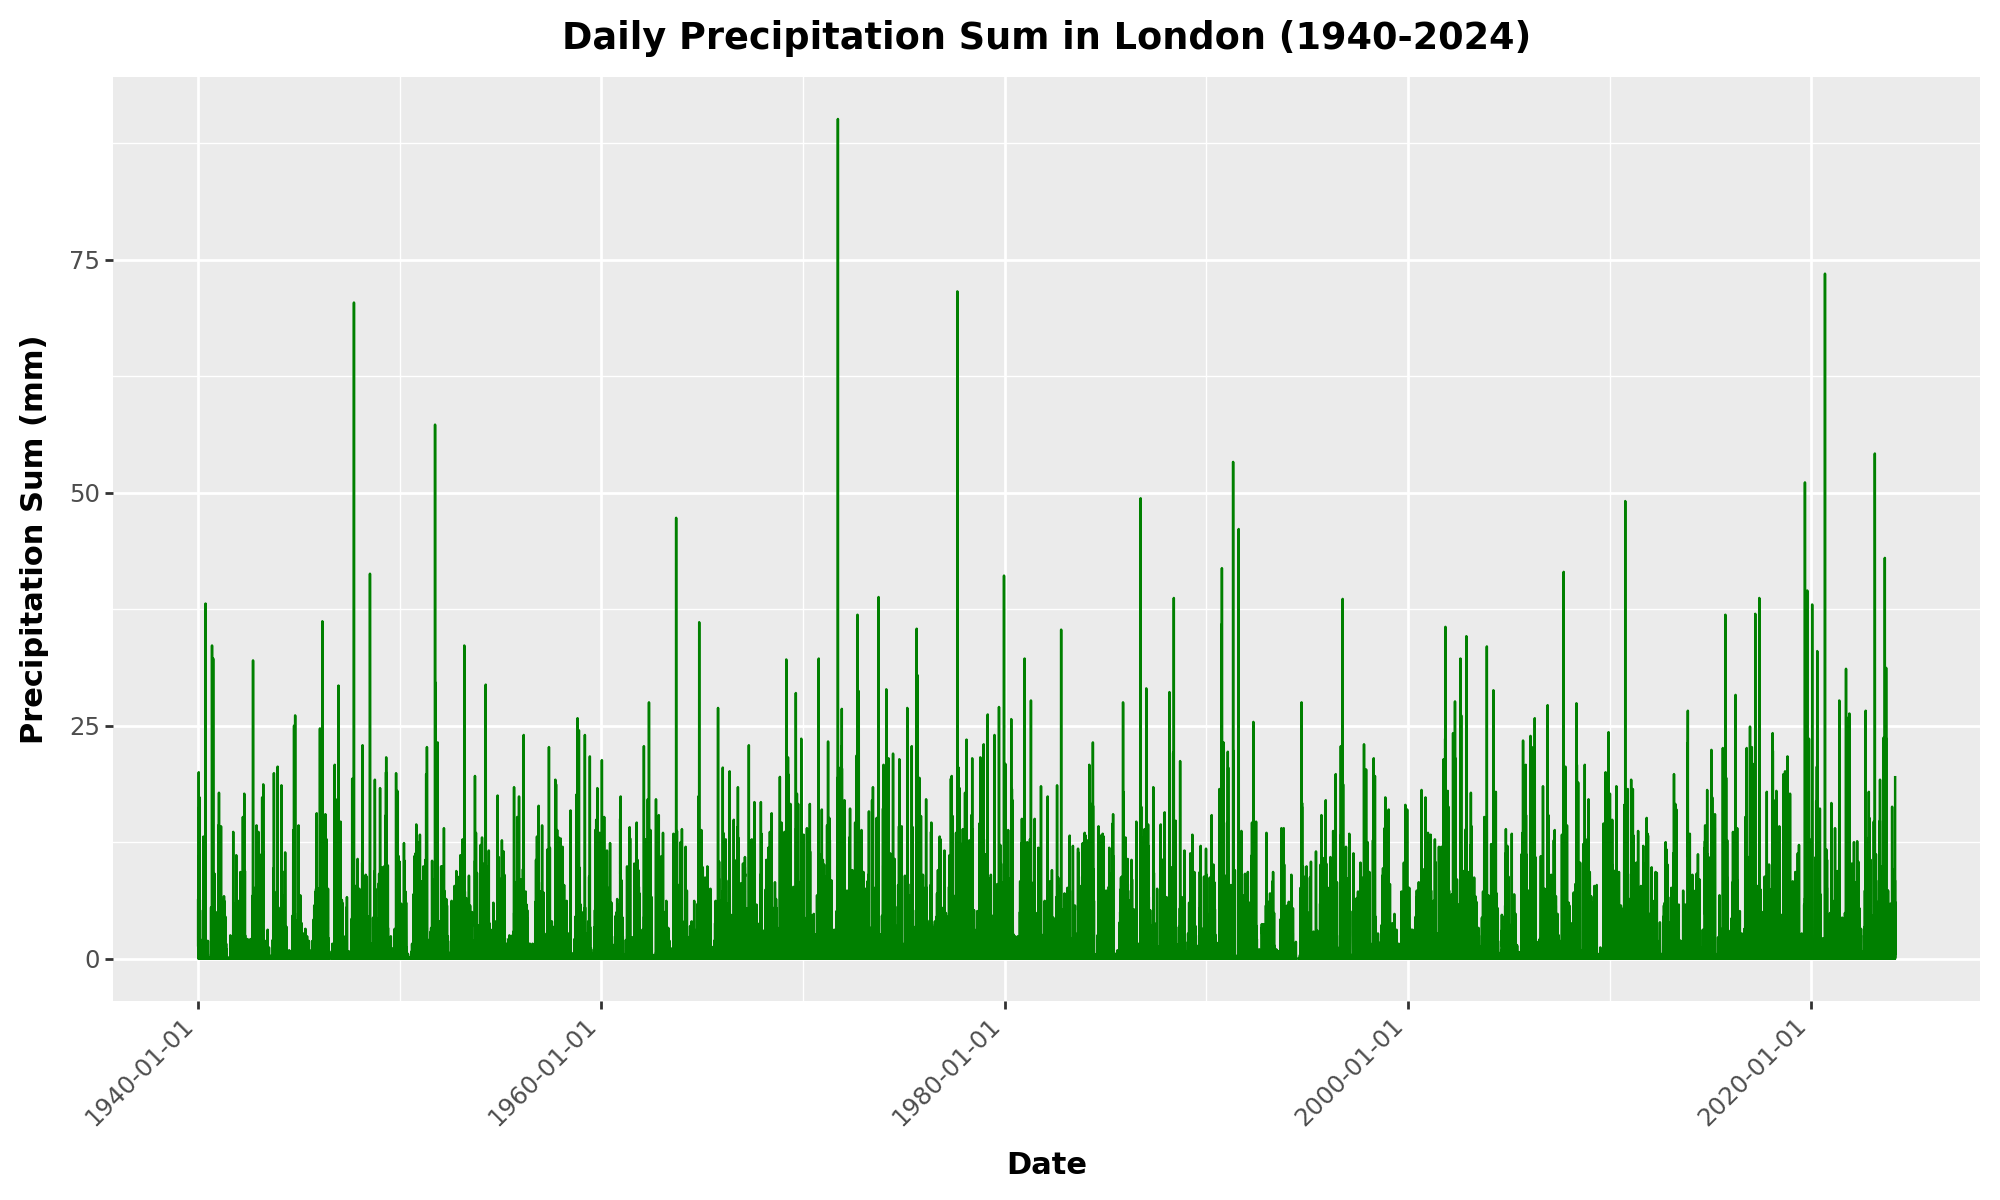

In [15]:
# Registering converters to avoid warning messages
register_matplotlib_converters()

# Creating a plot using Plotnine
plot = (ggplot(daily_dataframe) +
        aes(x='date', y='precipitation_sum') +
        geom_line(color='green') +
        labs(title='Daily Precipitation Sum in London (1940-2024)', x='Date', y='Precipitation Sum (mm)') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6))  # Adjust the figure size
       )

# Displaying the plot
print(plot)


/var/folders/z0/lgs3gf5503zcdkll0zsjwyx40000gn/T/ipykernel_38455/4011817845.py:19: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


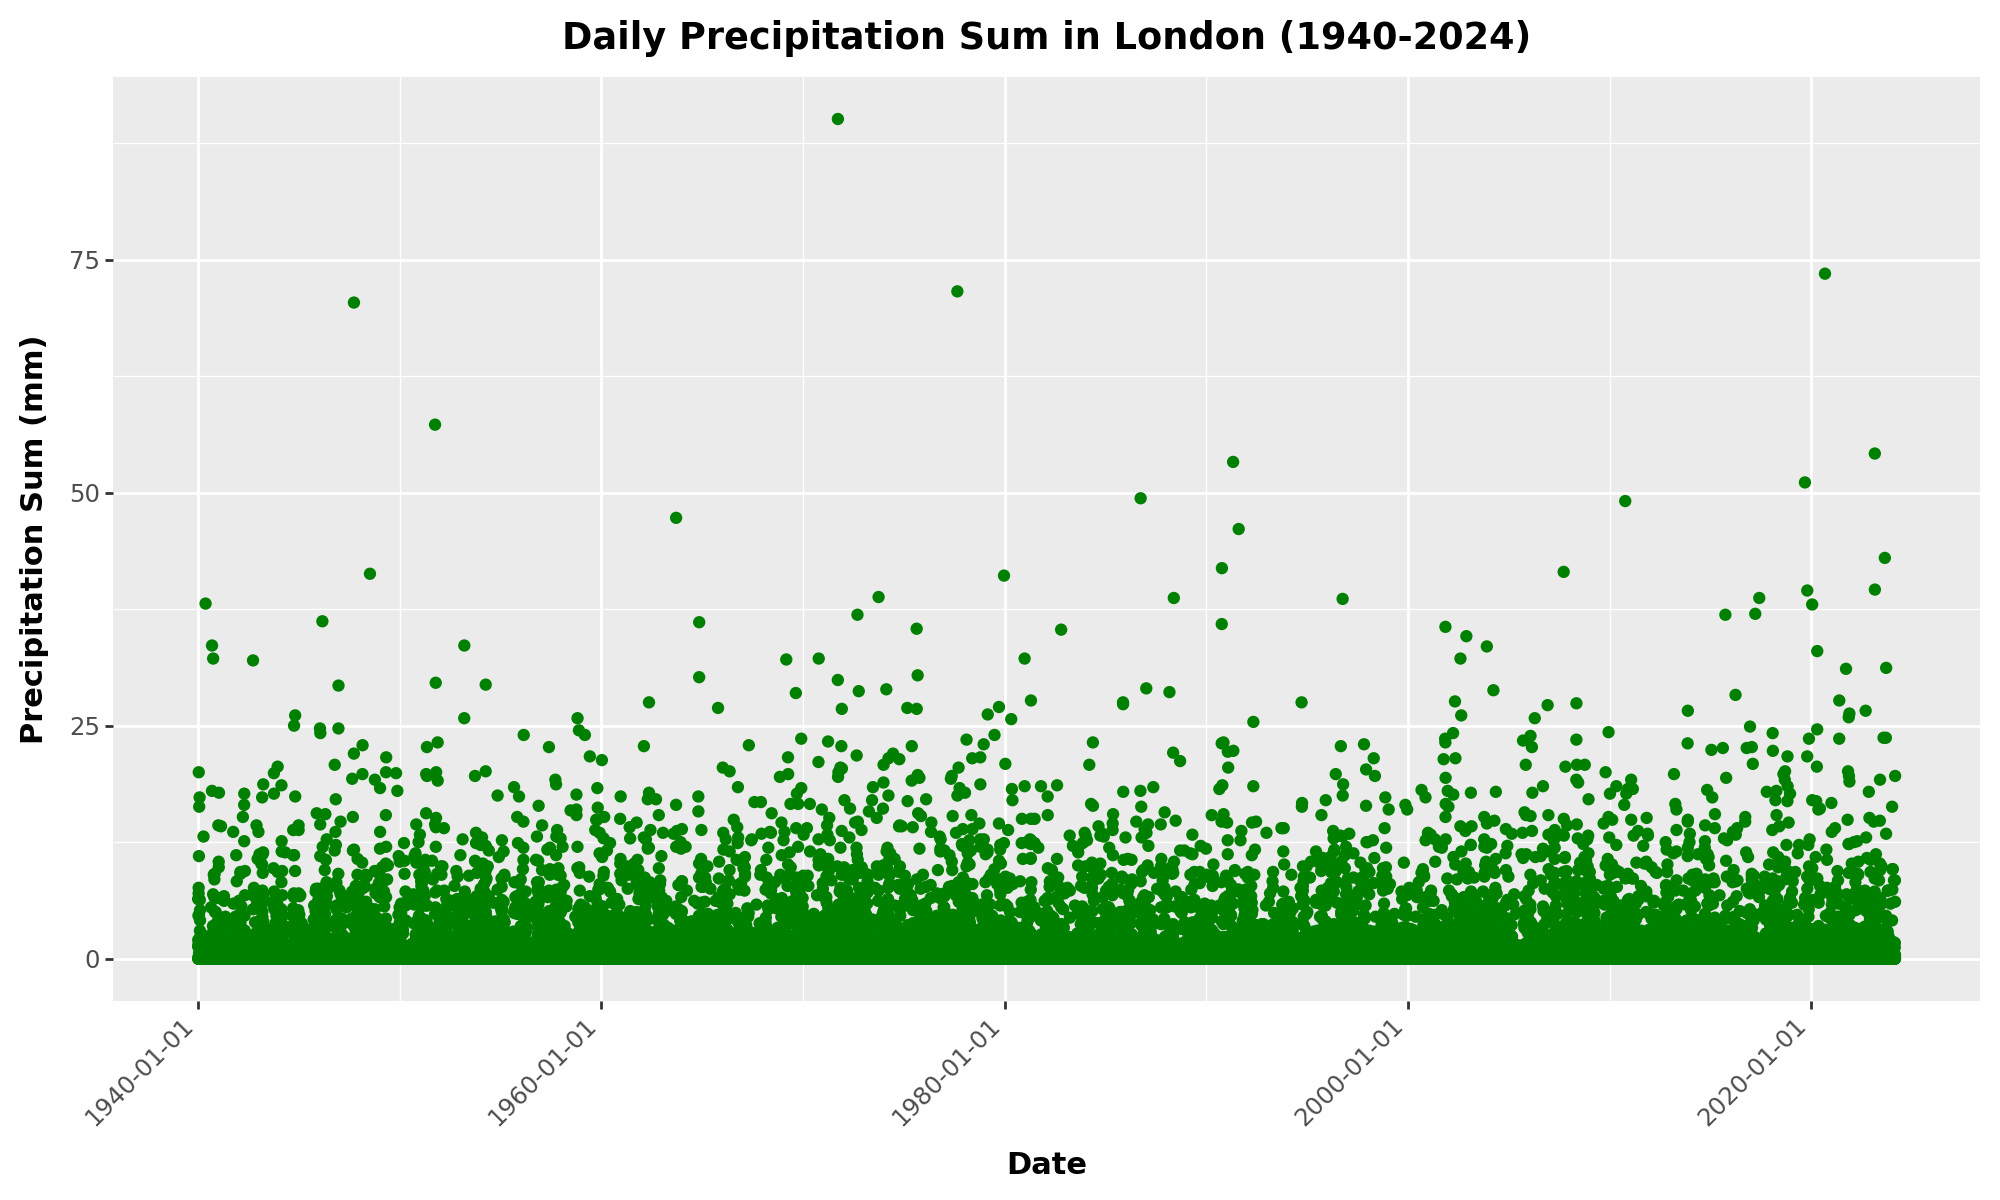

In [16]:
from plotnine import ggplot, aes, geom_point, labs, theme, element_text
from pandas.plotting import register_matplotlib_converters

# Registering converters to avoid warning messages
register_matplotlib_converters()

# Creating a plot using Plotnine with points
plot = (ggplot(daily_dataframe) +
        aes(x='date', y='precipitation_sum') +
        geom_point(color='green') +  # Change to geom_point() for points
        labs(title='Daily Precipitation Sum in London (1940-2024)', x='Date', y='Precipitation Sum (mm)') +
        theme(axis_text_x=element_text(angle=45, hjust=1),
              axis_title=element_text(weight='bold'),
              plot_title=element_text(weight='bold')) +
        theme(figure_size=(10, 6))  # Adjust the figure size
       )

# Displaying the plot
print(plot)